In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy as cart
import cartopy.crs as ccrs

from parcels import FieldSet

In [2]:
readdir_ocean_rcp = '/data/oceanparcels/input_data/CESM/0.1_deg/rcp8.5/ocean/arctic/'
fieldfile_ocean_rcp = 'daily_CESM_0.1degree_rcp8.5run_years_2000-2010_arctic.nc'
readdir_mesh = '/scratch/DaanR/fields/'
meshfile = 'POP_grid_coordinates.nc'

writedir = '/scratch/DaanR/psets/'

In [3]:
ds_rcp = xr.open_dataset(readdir_ocean_rcp+fieldfile_ocean_rcp)
POP_mesh = xr.open_dataset(readdir_mesh+meshfile)

U_rcp = ds_rcp['UVEL_5m']
V_rcp = ds_rcp['VVEL_5m']
ULAT = POP_mesh['ULAT']
ULON = POP_mesh['ULON']

In [4]:
ds_rcp

<xarray.Dataset>
Dimensions:  (record: 4007, time: 1, x: 3600, y: 600)
Coordinates:
  * time     (time) float64 2e+07
Dimensions without coordinates: record, x, y
Data variables:
    UVEL_5m  (record, time, y, x) float32 ...
    VVEL_5m  (record, time, y, x) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0 (http://...
    Conventions:                POP MOVIE conventions
    history:                    Mon Sep 16 16:30:22 2019: ncecat daan_1.nc da...
    title:                      POP MOVIE file
    nsteps_total:               240
    iyear:                      2000
    imonth:                     1
    iday:                       10
    tday:                       1.0
    NCO:                        "4.6.0"
    history_of_appended_files:  Mon Sep 16 15:52:22 2019: Appended file VVEL_...
    CDO:                        Climate Data Operators version 1.7.0 (http://...
    nco_openmp_thread_number:   1

The netCDF file consists of four dimensions:
 - record : integers describing the index (day since ...)
 - time : float describing start date
 - x : longitude indices
 - y : latitude indices

In [5]:
ds_rcp.time.values # 9 Januari 2000

array([20000109.])

In [6]:
ds_rcp.record.values

array([   0,    1,    2, ..., 4004, 4005, 4006])

Now we try to load the fieldset into parcels. We ignore the 'time' dimension and use the 'record' index instead. We manually pass 4007 timestamps, starting at 9 January 2000.

In [7]:
timestamps = [[np.datetime64('2000-01-09', 'D') + np.timedelta64(day, 'D') for day in range(4007)]]

fieldfile = readdir_ocean_rcp + fieldfile_ocean_rcp
meshfile = readdir_mesh + meshfile

filenames = {'U': {'lon': meshfile,
                   'lat': meshfile,
                   'data':fieldfile},
             'V': {'lon': meshfile,
                   'lat': meshfile,
                   'data':fieldfile}}

variables = {'U': 'UVEL_5m',
             'V': 'VVEL_5m'}

dimensions = {'U': {'time': 'record',
                        'lat': 'ULAT',
                        'lon': 'ULON'},
                  'V': {'time': 'record',
                        'lat': 'ULAT',
                        'lon': 'ULON'}}

fieldset = FieldSet.from_pop(filenames, variables, dimensions, allow_time_extrapolation = False, timestamps = timestamps)
fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
fieldset.V.vmax = 10; fieldset.V.vmin = -10;
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1);

`fieldset.U.timestamps` is properly loaded:

In [17]:
fieldset.U.timestamps;

# Plots

In [9]:
def set_circular_boundary(ax):
    theta = np.linspace(0, 2*np.pi, 400)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    return circle

U at index 0:

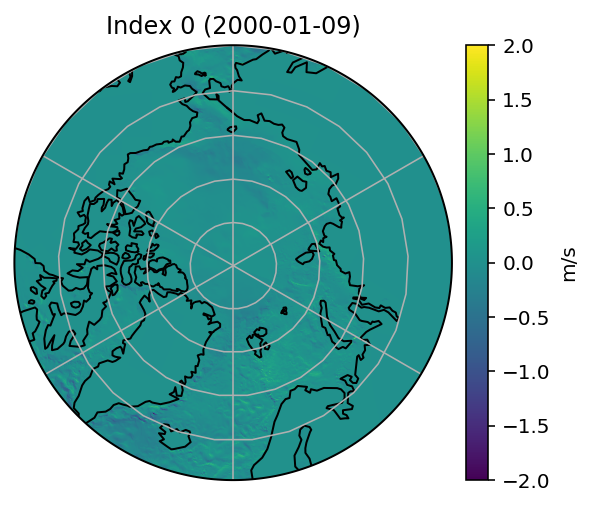

In [19]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None))
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
circle_clip = set_circular_boundary(ax)
###
plotfield = ax.pcolormesh(fieldset.U.lon, fieldset.U.lat, fieldset.U.data[0,:,:], transform=ccrs.PlateCarree(), vmin=-2, vmax=2, clip_path=(circle_clip, ax.transAxes))
###
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(plotfield, cax=ax_cb)
cbar.ax.set_ylabel("m/s")
ax.set_title(f"Index 0 ({fieldset.U.timestamps[0][0]})")
plt.show()

U at index 2:

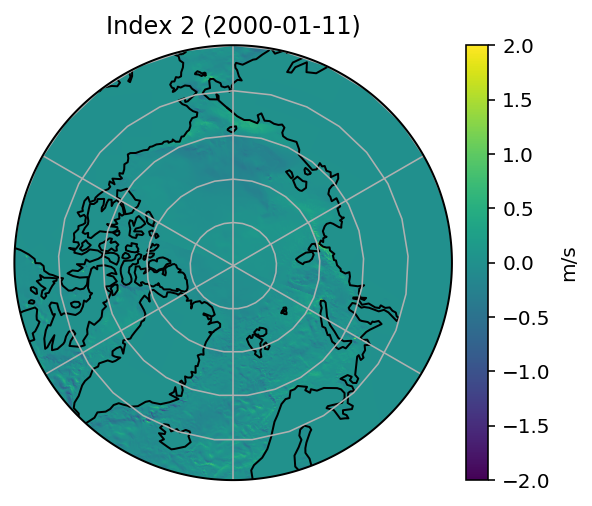

In [20]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None))
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
circle_clip = set_circular_boundary(ax)
###
plotfield = ax.pcolormesh(fieldset.U.lon, fieldset.U.lat, fieldset.U.data[2,:,:], transform=ccrs.PlateCarree(), vmin=-2, vmax=2, clip_path=(circle_clip, ax.transAxes))
###
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(plotfield, cax=ax_cb)
cbar.ax.set_ylabel("m/s")
ax.set_title(f"Index 2 ({fieldset.U.timestamps[0][2]})")
plt.show()

Plot difference between the two

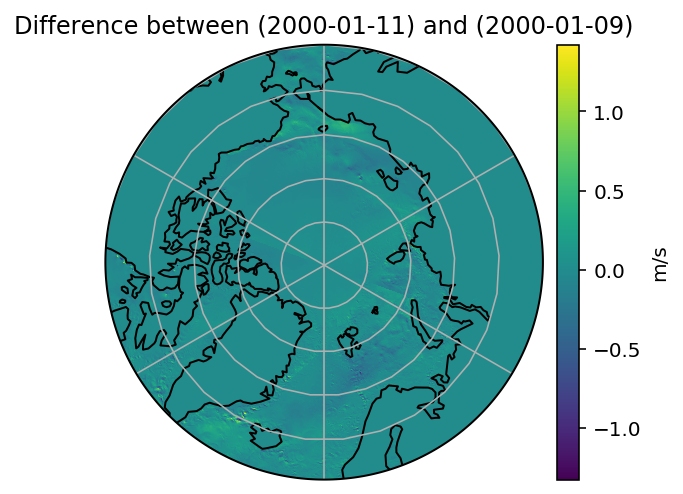

In [21]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None))
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
circle_clip = set_circular_boundary(ax)
###
plotfield = ax.pcolormesh(fieldset.U.lon, fieldset.U.lat, fieldset.U.data[2,:,:]-fieldset.U.data[0,:,:], transform=ccrs.PlateCarree(), clip_path=(circle_clip, ax.transAxes))
###
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(plotfield, cax=ax_cb)
cbar.ax.set_ylabel("m/s")
ax.set_title(f"Difference between ({fieldset.U.timestamps[0][2]}) and ({fieldset.U.timestamps[0][0]})")
plt.show()

No velocity difference is loaded between timestep zero and two, while it does exist in the dataset:

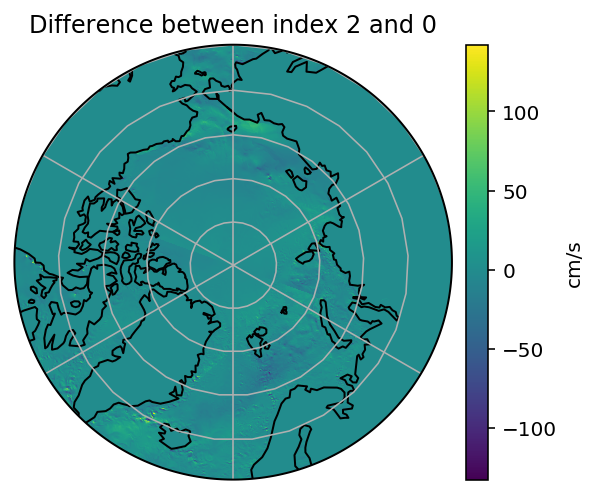

In [29]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None))
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
circle_clip = set_circular_boundary(ax)
###
plotfield = ax.pcolormesh(ULON, ULAT, U_rcp[2,0,:,:] - U_rcp[0,0,:,:], transform=ccrs.PlateCarree(), clip_path=(circle_clip, ax.transAxes))
###
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(plotfield, cax=ax_cb)
cbar.ax.set_ylabel("cm/s")
ax.set_title(f"Difference between index 2 and 0")
plt.show()